**Librerías**

---



In [ ]:
!pip install plotnine num2words nltk

In [ ]:
import collections
import gzip
import json
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import torch
import unicodedata
import nltk
from collections import Counter
from gensim.models import Word2Vec
from matplotlib.pyplot import *
from nltk import FreqDist, RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from num2words import num2words
from plotnine import aes, geom_bar, ggplot, labs, theme_minimal
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from urllib.request import urlopen
from gensim.models import Word2Vec
from nltk import FreqDist, RegexpTokenizer, word_tokenize
from textblob import TextBlob

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

**Descarga de datos**

---



In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Pet_Supplies_5.json.gz

--2023-09-09 17:26:00--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Pet_Supplies_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36119369 (34M) [application/x-gzip]
Saving to: ‘reviews_Pet_Supplies_5.json.gz.2’

reviews_Pet_Supplie 100%[===================>]  34.45M  10.5MB/s    in 3.3s    

2023-09-09 17:26:03 (10.5 MB/s) - ‘reviews_Pet_Supplies_5.json.gz.2’ saved [36119369/36119369]



E**xploración previa del dataset**

---


Se ha descargado el archivo y se ha guardado en un drive de manera manual para poderlo utilizar en el resto de notebooks.

In [ ]:
### load the meta data

data = []
with gzip.open('reviews_Pet_Supplies_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

157836
{'reviewerID': 'A14CK12J7C7JRK', 'asin': '1223000893', 'reviewerName': 'Consumer in NorCal', 'helpful': [0, 0], 'reviewText': "I purchased the Trilogy with hoping my two cats, age 3 and 5 would be interested.  The 3 yr old cat was fascinated for about 15 minutes but when the same pictures came on, she got bored.  The 5 year old watched for about a few minutes but then walked away. It is possible that because we have a wonderful courtyard full of greenery and trees and one of my neighbors has a bird feeder, that there is enough going on outside that they prefer real life versus a taped version.  I will more than likely pass this on to a friend who has cats that don't have as much wildlife to watch as mine do.", 'overall': 3.0, 'summary': 'Nice Distraction for my cats for about 15 minutes', 'unixReviewTime': 1294790400, 'reviewTime': '01 12, 2011'}


In [ ]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

import os
import pandas as pd

# Especifica la ruta del directorio donde deseas guardar el archivo CSV
directory_path = '../data'

# Crea el directorio si no existe
if not os.path.exists(directory_path):
    os.makedirs(directory_path)

# Guarda el DataFrame como un archivo CSV en el directorio especificado
df.to_csv(os.path.join(directory_path, 'corpus.csv'), index=False)

df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3.0,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011"
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",There are usually one or more of my cats watch...,5.0,Entertaining for my cats,1379116800,"09 14, 2013"
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",I bought the triliogy and have tested out all ...,4.0,Entertaining,1355875200,"12 19, 2012"
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",My female kitty could care less about these vi...,4.0,Happy to have them,1305158400,"05 12, 2011"
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]","If I had gotten just volume two, I would have ...",3.0,You really only need vol 2,1330905600,"03 5, 2012"


In [ ]:
print(df.head())

       reviewerID        asin           reviewerName helpful  \
0  A14CK12J7C7JRK  1223000893     Consumer in NorCal  [0, 0]   
1  A39QHP5WLON5HV  1223000893        Melodee Placial  [0, 0]   
2  A2CR37UY3VR7BN  1223000893       Michelle Ashbery  [0, 0]   
3  A2A4COGL9VW2HY  1223000893             Michelle P  [2, 2]   
4  A2UBQA85NIGLHA  1223000893  Tim  Isenhour "Timbo"  [6, 7]   

                                          reviewText  overall  \
0  I purchased the Trilogy with hoping my two cat...      3.0   
1  There are usually one or more of my cats watch...      5.0   
2  I bought the triliogy and have tested out all ...      4.0   
3  My female kitty could care less about these vi...      4.0   
4  If I had gotten just volume two, I would have ...      3.0   

                                             summary  unixReviewTime  \
0  Nice Distraction for my cats for about 15 minutes      1294790400   
1                           Entertaining for my cats      1379116800   
2       

In [ ]:
# Contar el número de revisiones para cada calificación de estrellas
star_ratings_count = df['overall'].value_counts().sort_index()

# Imprimir el número de revisiones para cada calificación
print("Número de revisiones para cada calificación de estrellas:")
print(star_ratings_count)



Número de revisiones para cada calificación de estrellas:
1.0     8748
2.0     8907
3.0    15933
4.0    27995
5.0    96253
Name: overall, dtype: int64


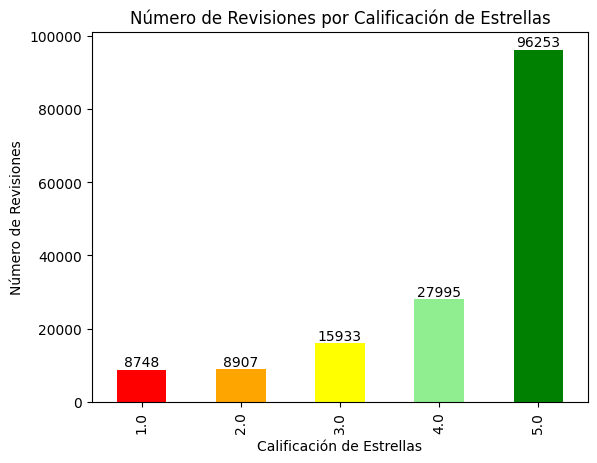

In [ ]:
# Obtener las calificaciones de estrellas únicas y contar sus revisiones correspondientes
star_ratings_count = df['overall'].value_counts().sort_index()

# Crear el gráfico de barras
fig, ax = plt.subplots()
bars = star_ratings_count.plot(kind='bar', color=['red', 'orange', 'yellow', 'lightgreen', 'green'])

# Etiquetas y título
plt.xlabel('Calificación de Estrellas')
plt.ylabel('Número de Revisiones')
plt.title('Número de Revisiones por Calificación de Estrellas')

# Agregar el número del eje Y dentro de las barras
for i, v in enumerate(star_ratings_count):
    ax.text(i, v + 50, str(v), ha='center', va='bottom', fontsize=10, color='black')

# Mostrar el gráfico
plt.show()

**Balanceamiento de los datos y captura de muestra**

---



In [ ]:
# Número de muestras a tomar por cada calificación de estrellas (teniendo en cuenta los grupos, 1 y 2 negativos y 3,4,5 positivos)
num_samples_per_star = {
    1: 750,
    2: 750,
    3: 500,
    4: 500,
    5: 500
}

# Crear un DataFrame vacío para almacenar las muestras
sampled_df = pd.DataFrame()

# Tomar muestras de cada calificación de estrellas y agregarlas al DataFrame de muestras
for star_rating, num_samples in num_samples_per_star.items():
    samples = df[df['overall'] == star_rating].sample(n=num_samples, random_state=42)
    sampled_df = pd.concat([sampled_df, samples])

# Reiniciar el índice del DataFrame resultante
sampled_df = sampled_df.reset_index(drop=True)

# Guardar las muestras en un archivo CSV
sampled_df.to_csv('sampled_data_file.csv', index=False)

# Imprimir el resultado
print("Muestras balanceadas por calificación de estrellas:")
print(sampled_df['overall'].value_counts().sort_index())

Muestras balanceadas por calificación de estrellas:
1.0    750
2.0    750
3.0    500
4.0    500
5.0    500
Name: overall, dtype: int64


In [ ]:
# Guardar el csv
output_path_sampled = '../data/corpusMini_df.csv'  # Reemplaza con la ruta deseada

# Guarda el DataFrame como un archivo CSV en la ubicación especificada
sampled_df.to_csv(output_path_sampled, index=False)


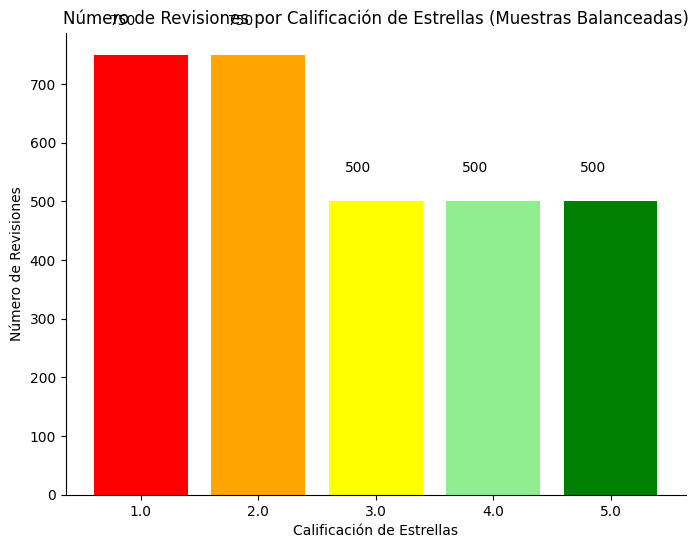

In [ ]:
# Contar el número de revisiones para cada calificación de estrellas en las muestras balanceadas
star_ratings_count = sampled_df['overall'].value_counts().sort_index()

# Definir colores para cada calificación de estrellas (1 a 5)
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(8, 6))

# Crear las barras
bars = ax.bar(star_ratings_count.index.astype(str), star_ratings_count, color=colors)

# Agregar el número del eje Y dentro de las barras
for bar, count in zip(bars, star_ratings_count):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, count + 50, str(count), ha='center', color='black', fontsize=10)

# Personalizar el gráfico
ax.set_title('Número de Revisiones por Calificación de Estrellas (Muestras Balanceadas)')
ax.set_xlabel('Calificación de Estrellas')
ax.set_ylabel('Número de Revisiones')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Mostrar el gráfico
plt.show()


In [ ]:
# Busca el patrón 'getTime' en todo el DataFrame
filtered_df = sampled_df[sampled_df.apply(lambda row: row.astype(str).str.contains('getTime').any(), axis=1)]

# Imprime el DataFrame resultante
print(filtered_df)

Empty DataFrame
Columns: [reviewerID, asin, reviewerName, helpful, reviewText, overall, summary, unixReviewTime, reviewTime, sentiment]
Index: []


In [ ]:
# Etiquetar las revisiones como buenas (1) o malas (0)
sampled_df['sentiment'] = sampled_df['overall'].apply(lambda x: 1 if x >= 3 else 0)

# Verificar las etiquetas para una muestra de revisiones
sample_size_to_check = 10
sample_to_check = sampled_df.sample(n=sample_size_to_check, random_state=42)

# Imprimir la muestra para verificación
print("Muestra de revisiones etiquetadas:")
print(sample_to_check[['overall', 'sentiment']])


Muestra de revisiones etiquetadas:
      overall  sentiment
1801      3.0          1
1190      2.0          0
1817      3.0          1
251       1.0          0
2505      5.0          1
1117      2.0          0
1411      2.0          0
2113      4.0          1
408       1.0          0
2579      5.0          1


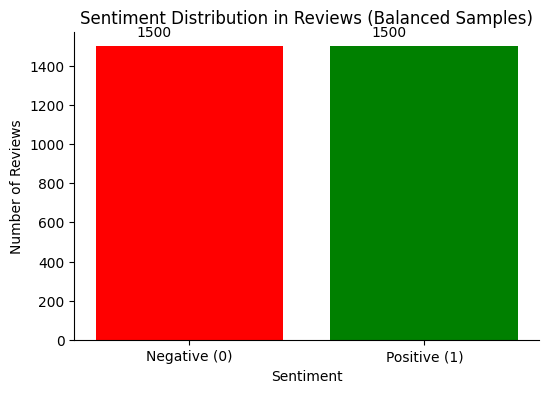

In [ ]:
# Count the number of reviews with sentiment 0 and 1
sentiment_counts = sampled_df['sentiment'].value_counts()

# Define colors for sentiment 0 (red) and sentiment 1 (green)
colors = ['red', 'green']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 4))

# Create the stacked bars
bars = ax.bar(sentiment_counts.index.astype(str), sentiment_counts, color=colors)

# Add labels on the bars
for bar, count in zip(bars, sentiment_counts):
    ax.text(bar.get_x() + bar.get_width() / 2 - 0.15, count + 50, str(count), ha='center', color='black', fontsize=10)

# Customize the plot
ax.set_title('Sentiment Distribution in Reviews (Balanced Samples)')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Reviews')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set labels for the X-axis
ax.set_xticks(sentiment_counts.index)
ax.set_xticklabels(['Negative (0)', 'Positive (1)'])

# Show the plot
plt.show()



División simple por tokens


In [ ]:
#Pasamos a minúsculas y realizamos una división simple por tokens en el siguiente código.
splitted_reviews =sampled_df['reviewText'].str.lower().str.split()

In [ ]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

In [ ]:
# Calcular la cardinalidad del vocabulario
vocab_cardinality = len(Counter(words))

# Imprimir la cardinalidad del vocabulario
print(f"Cardinalidad del Vocabulario: {vocab_cardinality}")

Cardinalidad del Vocabulario: 24909


In [ ]:
# Sample text data (replace with your preprocessed text)
text_data = " ".join(sampled_df['reviewText'])  # Use the correct column name

# Tokenized words
words = nltk.word_tokenize(text_data)

# Define the N for N-grams (e.g., 2 for bigrams, 3 for trigrams)
N_values = [2, 3]  # You can add more values for other N-grams

for N in N_values:
    # Generate N-grams
    n_grams = list(ngrams(words, N))

    # Calculate the frequency distribution of N-grams
    freq_dist = FreqDist(n_grams)

    # Get the most common N-grams
    most_common_ngrams = freq_dist.most_common(10)  # Change 10 to your desired number

    # Print the most common N-grams
    print(f"Top {N}-grams:")
    for ngram, frequency in most_common_ngrams:
        print(f"{ngram}: {frequency} times")
    print("\n")


Top 2-grams:
('.', 'I'): 3252 times
(',', 'but'): 1325 times
('.', 'The'): 1199 times
(',', 'and'): 1133 times
('of', 'the'): 1044 times
('.', 'It'): 992 times
('in', 'the'): 907 times
(',', 'I'): 818 times
('it', '.'): 814 times
('I', 'have'): 758 times


Top 3-grams:
('&', '#', '34'): 395 times
('#', '34', ';'): 395 times
('.', 'I', 'have'): 382 times
('I', 'do', "n't"): 256 times
('.', 'It', "'s"): 225 times
(',', 'but', 'it'): 186 times
('.', 'This', 'is'): 180 times
('it', '.', 'I'): 177 times
(',', 'but', 'I'): 177 times
('!', '!', '!'): 166 times




Viendo los ngrams resulta lógico que se han de utilizar stopwords

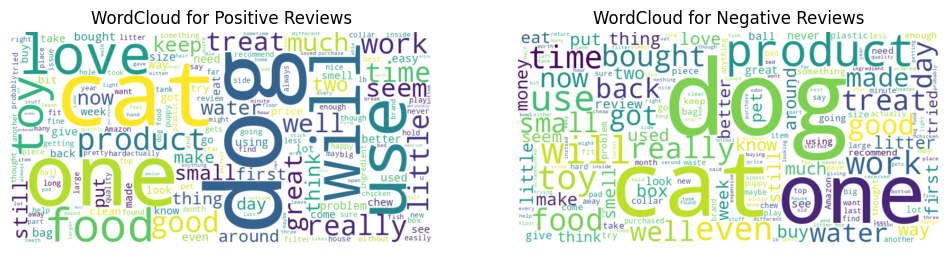

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample text data (replace with your preprocessed text)
positive_reviews = sampled_df[sampled_df['sentiment'] == 1]['reviewText'].str.cat(sep=' ')
negative_reviews = sampled_df[sampled_df['sentiment'] == 0]['reviewText'].str.cat(sep=' ')

# Create a WordCloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Create a WordCloud for negative reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot the WordClouds
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('WordCloud for Positive Reviews')
plt.axis("off")

plt.subplot(122)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('WordCloud for Negative Reviews')
plt.axis("off")

plt.show()

De los wordcloud se puede extraer que al ser reviews de compra de alimento de animales, dog y cat no son significativas, también se deberían de eliminar otras palabras como will, use, make, buy... que no aportan al análisis.

In [ ]:
w2v_params = {
    'sg': 1,
    'vector_size': 300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

In [ ]:
w2v_model = Word2Vec(**w2v_params)

In [ ]:
corpus_ = sampled_df['reviewText']
corpus_ = corpus_.str.split()

In [ ]:
w2v_model.build_vocab(corpus_)
w2v_model.train(corpus_, total_examples=len(corpus_), epochs=20)


(1231643, 2076040)

In [ ]:
# Obtén el número de palabras en el vocabulario
num_words = len(w2v_model.wv.key_to_index)
print('Vocabulario compuesto por {} palabras'.format(num_words))

Vocabulario compuesto por 2126 palabras


In [ ]:
import os

# Especifica la ruta del directorio donde deseas guardar el modelo
models_directory = '../models'

# Crea el directorio si no existe
if not os.path.exists(models_directory):
    os.makedirs(models_directory)


In [ ]:
w2v_model.save('../models/w2wmode.pkl')

Grupo: treat
Palabras: special, health, treat., extreme, named, peanut, ,, choice, sense, challenge

Grupo: love
Palabras: flavor, loved, enjoy, touch, LOVE, absolutely, Cats, dig, gives, sweet

Grupo: bed
Palabras: panel, foam, crate, 9, hard., Chihuahua, fleece, 60, harness, area.

Grupo: food
Palabras: food,, Wellness, foods, canned, food., results., mixed, human, dry, diet



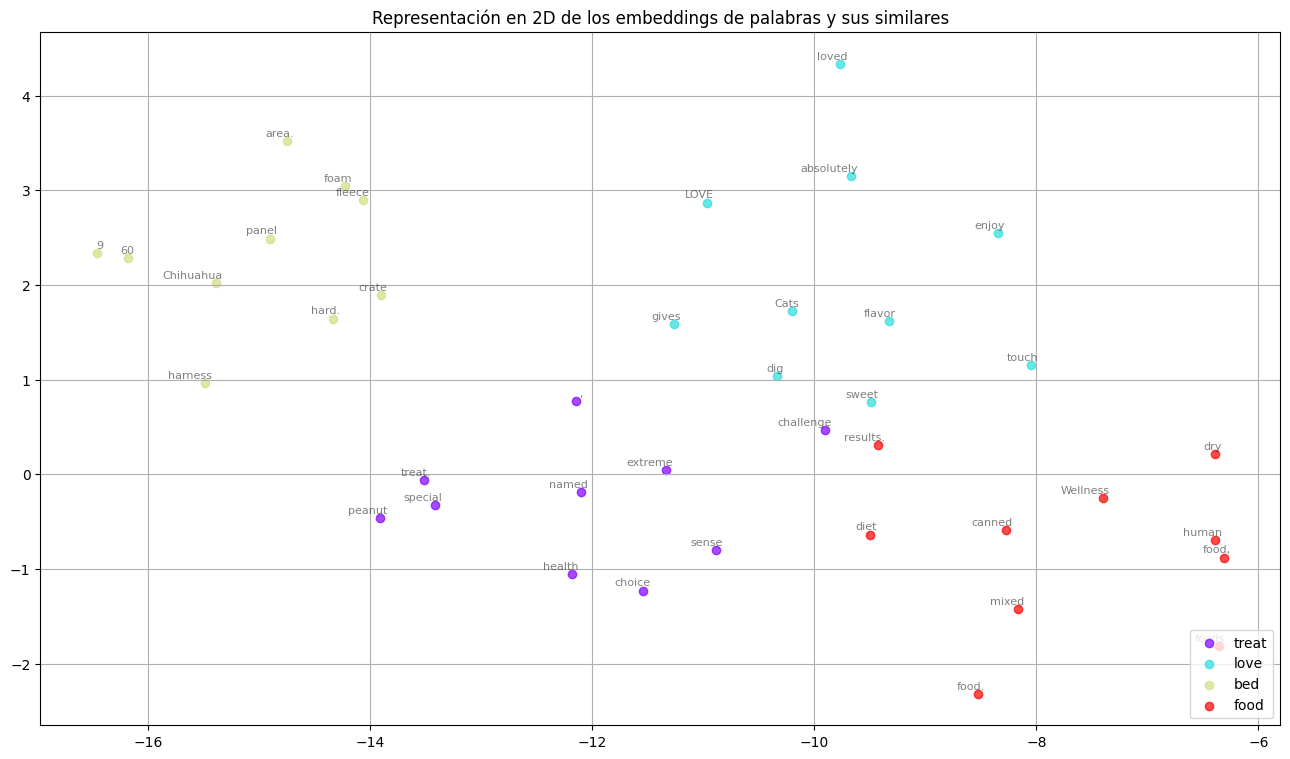

In [ ]:

%matplotlib inline

# Comprueba si el modelo ya está cargado
if 'model' not in locals():
    from gensim.models import Word2Vec

    # Carga tu modelo Word2Vec previamente guardado
    model = Word2Vec.load('../models/w2wmode.pkl')

# Resto del código (las mismas partes de búsqueda de palabras similares y visualización)
keys = ['treat', 'love', 'bed', 'food']
embedding_clusters = []
word_clusters = []

for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

# Resto del código para la visualización
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

# Función para visualizar palabras y sus similares en 2D
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
        plt.legend(loc=4)
        plt.grid(True)
        plt.title('Representación en 2D de los embeddings de palabras y sus similares')
        print(f'Grupo: {label}\nPalabras: {", ".join(words)}\n')

# Visualización de palabras y sus similares en 2D
tsne_plot_similar_words(keys, embeddings_2d, word_clusters)





Conclusiones:


*   Se escoge una muestra de 2500 reviews pues las entradas del dataset son muy elevadas para una exploración de datos >157000 en caso contrario esto genera unos tiempos de carga demasiado elevados.

*   Se deberían eliminar las stopwords, se ve muy claramente en las "nubes de palabras" y en los ngrams que hay muchos símbolos y palabras que no aportan nada, ya sean comas, ";" o palabras que están relacionadas con la temática de las reviews, dog, cat etc.

*   Parece que si que existen palabras relacionadas que se pueden ver a simple vista, por ejemplo, para treat, tenemos peanut, health, sense o choice que podriamos relacionar con la elección de la "chuchería", y para bed encontramos area, chihuahua y algunos números que se pueden relacionar con el tamaño.

*   Se podrían corregir y lematizar las palabras utilizando un diccionario inglés, también poner en minúscula todas las reviews para ahorrarnos que no indique LOVE como palabra relacionada con love (detectándolas diferentes)



